In [11]:
import cv2 
import os 
import numpy as np 
from random import shuffle 
from tqdm import tqdm

In [12]:
TRAIN_DIR = 'train'
TEST_DIR = 'test1'
IMG_SIZE = 50
LR = 1e-3

In [13]:
TRAIN_DIR

'train'

In [4]:
MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '6conv-basic')

In [14]:
def label_img(img): 
    word_label = img.split('.')[-3] 
    # DIY One hot encoder 
    if word_label == 'cat': return [1, 0] 
    elif word_label == 'dog': return [0, 1] 

In [15]:
def create_train_data(): 
    # Creating an empty list where we should the store the training data 
    # after a little preprocessing of the data 
    training_data = [] 
  
    # tqdm is only used for interactive loading 
    # loading the training data 
    for img in tqdm(os.listdir(TRAIN_DIR)): 
  
        # labeling the images 
        label = label_img(img) 
  
        path = os.path.join(TRAIN_DIR, img) 
  
        # loading the image from the path and then converting them into 
        # greyscale for easier covnet prob 
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
  
        # resizing the image for processing them in the covnet 
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) 
  
        # final step-forming the training data list with numpy array of the images 
        training_data.append([np.array(img), np.array(label)]) 
  
    # shuffling of the training data to preserve the random state of our data 
    shuffle(training_data) 
  
    # saving our trained data for further uses if required 
    np.save('train_data.npy', training_data) 
    return training_data 

In [16]:
def process_test_data(): 
    testing_data = [] 
    for img in tqdm(os.listdir(TEST_DIR)): 
        path = os.path.join(TEST_DIR, img) 
        img_num = img.split('.')[0] 
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) 
        testing_data.append([np.array(img), img_num]) 
          
    shuffle(testing_data) 
    np.save('test_data.npy', testing_data) 
    return testing_data 

In [17]:
train_data = create_train_data() 
test_data = process_test_data()

100%|██████████| 12500/12500 [02:20<00:00, 89.19it/s] 


In [33]:
train_data[0]

[array([[223, 191, 206, ..., 139, 131, 130],
        [219, 206, 230, ..., 165, 133, 132],
        [230, 215, 220, ..., 186, 142, 137],
        ...,
        [ 68, 165,  81, ..., 199, 100, 197],
        [198, 139, 109, ..., 153, 228, 144],
        [172, 107, 129, ..., 183,  66, 128]], dtype=uint8), array([0, 1])]

In [34]:
import tflearn 
from tflearn.layers.conv import conv_2d, max_pool_2d 
from tflearn.layers.core import input_data, dropout, fully_connected 
from tflearn.layers.estimator import regression
import tensorflow as tf

In [35]:
tf.reset_default_graph() 
convnet = input_data(shape =[None, IMG_SIZE, IMG_SIZE, 1], name ='input') 
  
convnet = conv_2d(convnet, 32, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = conv_2d(convnet, 64, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = conv_2d(convnet, 128, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = conv_2d(convnet, 64, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = conv_2d(convnet, 32, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = fully_connected(convnet, 1024, activation ='relu') 
convnet = dropout(convnet, 0.8) 
  
convnet = fully_connected(convnet, 2, activation ='softmax') 
convnet = regression(convnet, optimizer ='adam', learning_rate = LR, 
      loss ='categorical_crossentropy', name ='targets') 
  
model = tflearn.DNN(convnet, tensorboard_dir ='log')

In [36]:
train = train_data[:-500] 
test = train_data[-500:] 

In [37]:
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1) 
Y = [i[1] for i in train] 
test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1) 
test_y = [i[1] for i in test] 

In [38]:
model.fit({'input': X}, {'targets': Y}, n_epoch = 8,  
    validation_set =({'input': test_x}, {'targets': test_y}),  
    snapshot_step = 500, show_metric = True, run_id = MODEL_NAME) 
model.save(MODEL_NAME) 

Training Step: 1914  | total loss: 0.41561 | time: 30.976s
| Adam | epoch: 005 | loss: 0.41561 - acc: 0.8146 -- iter: 24448/24500
Training Step: 1915  | total loss: 0.40962 | time: 32.059s
| Adam | epoch: 005 | loss: 0.40962 - acc: 0.8206 | val_loss: 0.49787 - val_acc: 0.7680 -- iter: 24500/24500
--
INFO:tensorflow:/home/abhay/Damage estimator/AWS Damage Estimator-20190805T071237Z-001/CNN_test/dogsvscats-0.001-6conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


In [26]:
import matplotlib.pyplot as plt

In [27]:
test_data = np.load('test_data.npy') 
  
fig = plt.figure()

<Figure size 432x288 with 0 Axes>

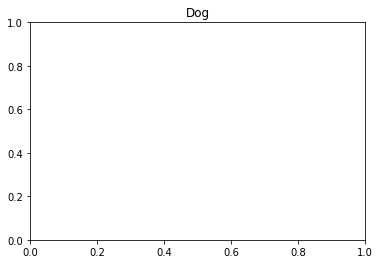

In [28]:
for num, data in enumerate(test_data[:20]): 
    # cat: [1, 0] 
    # dog: [0, 1] 
      
    img_num = data[1] 
    img_data = data[0] 
      
    y = fig.add_subplot(4, 5, num + 1) 
    orig = img_data 
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1) 
  
    # model_out = model.predict([data])[0] 
    model_out = model.predict([data])[0] 
      
    if np.argmax(model_out) == 1: str_label ='Dog'
    else: str_label ='Cat'
          
    y.imshow(orig, cmap ='gray') 
    plt.title(str_label) 
    y.axes.get_xaxis().set_visible(False) 
    y.axes.get_yaxis().set_visible(False) 
plt.show()

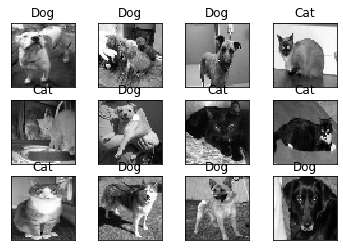

In [40]:
import matplotlib.pyplot as plt

# if you need to create the data:
#test_data = process_test_data()
# if you already have some saved:
test_data = np.load('test_data.npy')

fig=plt.figure()

for num,data in enumerate(test_data[:12]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()